# Double DQN From Scratch

The max operator in standard Q-Learning and DQN uses the same values to select and evaluate actions. This makes the value function likely to overestimate values, resulting in overoptimistic estimates.

The idea of Double Q-Learning is to reduce the overestimations by decomposing the max operation in the TD target into action selection and action evaluation.

# Imports & Constants

In [13]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import highway_env
import time

import pandas as pd

from IPython.display import clear_output

from agents import DQNAgent

# Double DQN

In [2]:
from typing import Dict


from numpy import ndarray
from torch._tensor import Tensor


class DDQNAgent(DQNAgent):
    """
    Class representing a Double DQN agent.
    """

    def _compute_dqn_loss(self, samples: Dict[str, ndarray]) -> Tensor:
        """
        Computes and returns the Double DQN loss.
        """
        device = self.device

        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)

        # This line is what makes the agent a Double DQN agent.
        next_q_value = self.dqn_target(next_state).gather( 
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        
        mask = 1 - done
        # Calculate the TD target
        target = (reward + self.gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

# Train an agent

In [3]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")

In [4]:
seed = 777

def seed_torch(seed: int):
    torch.manual_seed(seed)

    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [7]:
num_frames = 20_000
memory_size = 15_000
gamma = 0.8
batch_size = 32
target_update = 50
epsilon_decay = 1 / 4000

agent = DDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


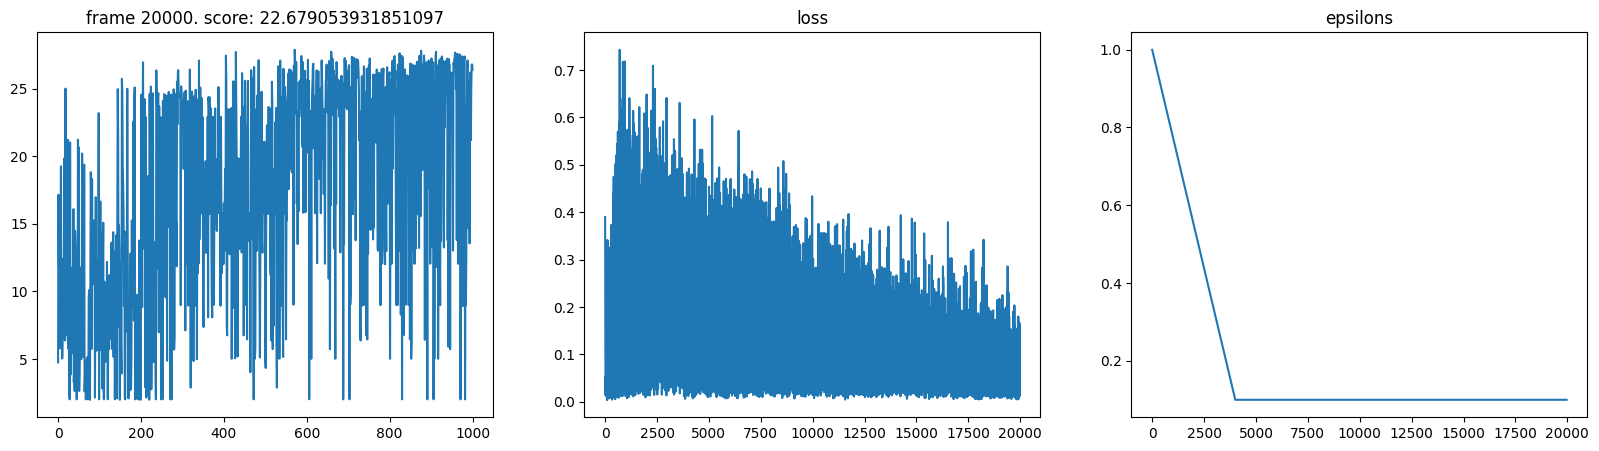

In [8]:
agent.train(num_frames)

# Test the agent

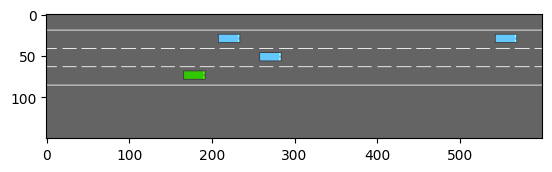

KeyboardInterrupt: 

In [19]:
while True:
    done = truncated = False
    obs, info = env.reset()
    obs = obs.flatten()

    while not (done or truncated):
        action = agent.predict(obs, True)
        obs, reward, done, truncated, info = env.step(action)
        obs = obs.flatten()

        clear_output(True)
        plt.imshow(env.render())
        plt.show()
        time.sleep(0.1)

In [9]:
agent.test("videos/d_dqn")

/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/d_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/d_dqn/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/d_dqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/d_dqn/rl-video-episode-0.mp4
score:  26.99863907906877
